In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
from scipy.integrate import simps
from matplotlib.ticker import FuncFormatter

In [2]:
#Fixed parameter values
pi = 1710; 
#beta1 =1.72;
mu =1/(83*365); 
eps =0.33;   #Youngji paper
tau = 0.8; tau = 0.8;
psi = 0.5; 
phi1, phi2 = 1/180, 1/180
h1= 0.0012; 
h2 = (1-0.74)*h1;
rho = 1/14; rhot =1/10; rhoh =1/10;
eta1= 0.71; eta2= 0.41; eta4= 0.85; eta3 = 0.46;
a = 1/3  # fixed to be 3 days  

theta = 0.5 # parameter adjusting reduced perception risk (assumed)
delta = 0.8  # proportion of tested people who quarantine/adhere to protective measures (assumed)
alpha1, alpha2 = 0.5, 0.5  # parameters which shows to which information people are more concerned

Dtilde, Btilde = 5, 5  # reactivity to information in vaccination
D, B = 1*Dtilde, 1*Btilde # reactivity to information in testing (assumed equal)
Fmax = 0.027; F10 = 0.0029; F20 = (0.9)*F10;
Tmax = 0.5; T10 = 0.03; T20 = 0.03    #Tmax is adjusted to have a good fit

# Fitted parameters
k1=  0.51
beta1=  0.67
beta2=  0.39
xi=  0.99
d1 =0.000071; d2 = 0.000073;  

In [3]:
# Initial conditions
NN = 51815808
V2_0 = 2891 #int(0.87*Data_Omicron['new_vaccinations'].iloc[0])
V1_0 = 431; #int(0.13*Data_Omicron['new_vaccinations'].iloc[0])
E2_0 = 352645 #int(0.87*20*NewCases.iloc[0])
A2_0 = 70529 #int(0.2*E2_0)
I2_0 = 282116  #int(0.8*E2_0)
IT2_0 = 17632 #int(0.87*NewCases.iloc[0])
E1_0 = 52694 #int(0.13*20*NewCases.iloc[0])  # 0.13 indicates that 13% of the total population is in the first dynamics
A1_0 = 10538 #int(0.2*E1_0)
I1_0 = 42155 #int(0.8*E1_0)
IT1_0 = 2634 #int(0.13*NewCases.iloc[0])
H_0 = 202  # ICU
R_0 = 200
Dth_0 = 15
MV_0 = k1*((I1_0 + I2_0 + IT1_0 + IT2_0 + H_0)/NN)
MN_0 = k1*((H_0 + d1*(I1_0+I2_0) + d2*H_0)/NN)
S2_0 = 40000000 # 0.9*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S3_0 = 4365186 #0.1*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S1_0 = NN-(S2_0 + S3_0 + V1_0 + V2_0 + E1_0 + E2_0 + A1_0 + A2_0 + I1_0 + I2_0 + IT1_0 + IT2_0 + H_0 + R_0)

In [4]:
# initial conditions 
x0 = [S1_0, S2_0, S3_0, V1_0, V2_0, E1_0, E2_0, A1_0, A2_0, I1_0, I2_0, IT1_0, IT2_0, H_0, R_0, Dth_0, MV_0, MN_0]

In [5]:
def model_eq(x,t):
    S1, S2, S3, V1, V2, E1, E2, A1, A2, I1, I2, I_T1, I_T2, H, R, Dth, MV, MN  = x
    dx = np.zeros(18)
    N= S1 + S2+ S3 + V1 + V2 + E1 + E2 + A1 + A2 + I1 + I2 + I_T1 + I_T2 + H + R
    
    T1 = T10 + (Tmax -T10)*(alpha1*(D*MV)/(1+D*MV) + (1-alpha1)*(B*MN)/(1+B*MN) )
    F1 = F10 + (Fmax -F10)*(alpha1*(Dtilde*MV)/(1+Dtilde*MV) + (1-alpha1)*(Btilde*MN)/(1+Btilde*MN))
    
    T2 = T20 + (Tmax -T20)*(alpha2*(theta*D*MV)/(1+theta*D*MV) + (1-alpha2)*(theta*B*MN)/(1+theta*B*MN) )
    F2 = F20 + (Fmax -F20)*(alpha2*(theta*Dtilde*MV)/(1+theta*Dtilde*MV) + (1-alpha2)*(theta*Btilde*MN)/(1+theta*Btilde*MN))
    
    L1 = beta1*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    L2 = beta2*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    
    dx[0] = pi-(F1 +L1 +mu)*S1
    dx[1] = phi1*V1 -((1-eta2)*L2+F2+mu)*S2
    dx[2] = phi2*R-((1-eta3)*L2+F2+mu)*S3
    dx[3] = F1*S1-phi1*V1-(1-eta1)*L2*V1-mu*V1
    dx[4] = F2*S2+F2*S3-(1-eta4)*L2*V2-mu*V2
    dx[5] = L1*S1-(eps+mu)*E1
    dx[6] = (1-eta1)*L2*V1+(1-eta4)*L2*V2+L2*((1-eta2)*S2+(1-eta3)*S3)-(mu+eps)*E2
    dx[7] = (1-tau)*eps*E1-xi*T1*A1-(rho+mu)*A1
    dx[8] = (1-tau)*eps*E2-xi*T2*A2-(rho+mu)*A2
    dx[9] = tau*eps*E1-T1*I1-(rho+d1+mu)*I1
    dx[10] = tau*eps*E2-T2*I2-(rho+d1+mu)*I2
    dx[11] = xi*T1*A1+T1*I1-(rhot+h1+mu)*I_T1
    dx[12] = xi*T2*A2+T2*I2-(rhot+h2+mu)*I_T2
    dx[13] = h1*I_T1+h2*I_T2-rhoh*H-(d2+mu)*H
    dx[14] = rho*(A1+A2+I1+I2)+rhot*(I_T1+I_T2)+rhoh*H-(phi2+mu)*R
    dx[15] = d1*(I1+I2)+d2*H
    dx[16] = a*(k1*((I_T1+I_T2+I1+I2+H)/NN)-MV) 
    dx[17] = a*(k1*((H + d1*(I1 + I2) + d2*H)/NN)-MN)
    return dx

In [6]:
t = np.linspace(0,120,120)

CI_base_case =  39893552.546101436
CI_immune_sev =  43661927.978366606
CI_immune_prev =  35828018.547773235
Maximum active cases =  [5471128.12677308, 6440985.001389092, 4278697.097742008]
Time of max cases =  [41.344537815126046, 45.3781512605042, 38.319327731092436]
Maximum test1 =  [0.09184492242647618, 0.14597561196158942, 0.1312089205898216]
Maximum test2 =  [0.06558497207197402, 0.03759776217956122, 0.08747680005845035]
Maximum Vacc1 =  [0.006071197086123566, 0.008846834570796394, 0.008089648906839789]
Maximum Vacc2 =  [0.004456632912415843, 0.0030042753607648896, 0.00559267904984171]
Mean test1 =  [0.06224556261362169, 0.09283420759944104, 0.0827781210024648]
Mean test2 =  [0.047775574683910076, 0.033939815539167785, 0.05882016335992761]
Mean Vacc1 =  [0.004553442678698475, 0.006121924262013892, 0.005606282374807237]
Mean Vacc2 =  [0.0035324388649799294, 0.0028144512787240472, 0.004105582519890712]


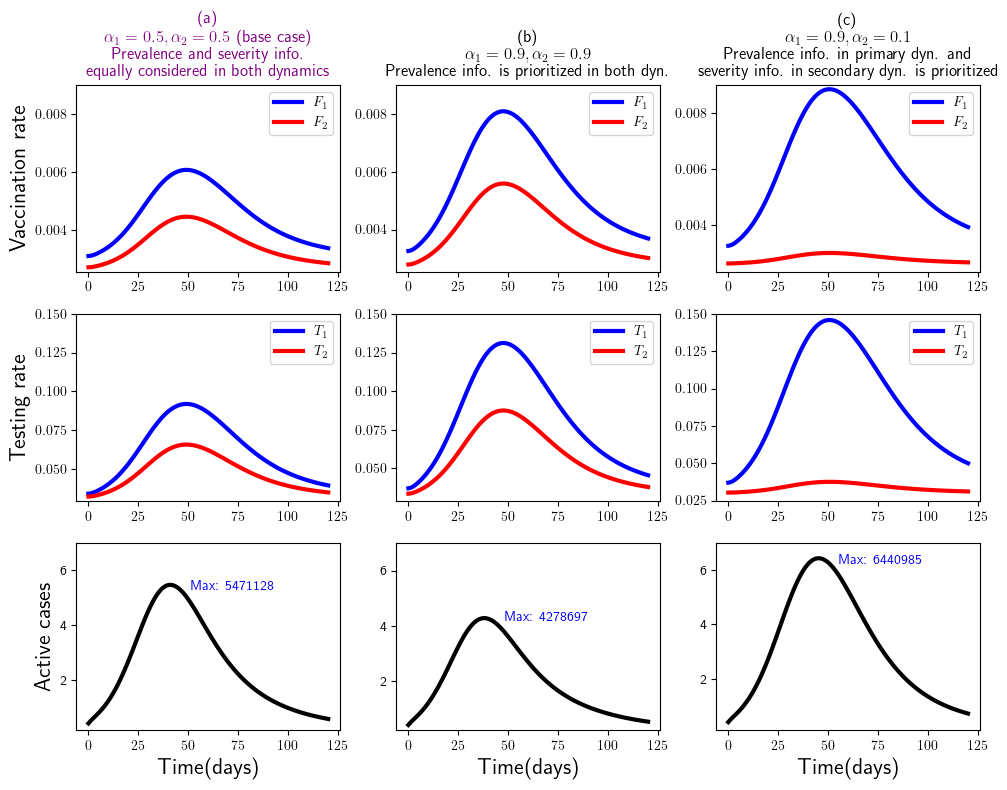

In [7]:
def millions_formatter(x, pos):    
    return f'{(x / 1000000):.0f}'
k1 = 0.51
a = 1/3
Max_cases = []; Time_max =[]
MaxTest_1 = []; MaxTest_2 =[]
MeanTest_1 = []; MeanTest_2 =[]
MaxVac_1 = []; MaxVac_2 = []
MeanVac_1 = []; MeanVac_2 = []
Cum_Inc = []
Cum_infectious1 = np.zeros(len(t)); 
alpha = [0.1,0.5,0.9]
fig, axs = plt.subplots(3,3,figsize=(10,8))
for j in [0,1,2]:
    if j == 1:
        alpha1 = alpha[j+1]; alpha2 = alpha[j-1]
    elif j == 2:
        alpha1 = alpha[j]; alpha2 = alpha[j]
    else:
        alpha1 = alpha[j+1]; alpha2 = alpha[j+1]
    
    x = odeint(model_eq,x0,t)
    In1 = x[:,7] + x[:,9] + x[:,8] + x[:,10] 
    New_active_cases = eps*(x[:,5] + x[:,6] ) 
    Test1= T10 + (Tmax -T10)*(alpha1* np.divide(D*x[:,16],(1+D*x[:,16])) + (1-alpha1)* np.divide(B*x[:,17],(1+B*x[:,17]))) 
    Vac1 = F10 + (Fmax -F10)*(alpha1* np.divide(Dtilde*x[:,16],(1+Dtilde*x[:,16])) + (1-alpha1)* np.divide(Btilde*x[:,17],(1+Btilde*x[:,17]))) 
    Test2 = T20 + (Tmax -T20)*(alpha2* np.divide(theta*D*x[:,16],(1+theta*D*x[:,16])) + (1-alpha2)* np.divide(theta*B*x[:,17],(1+theta*B*x[:,17]))) 
    Vac2 = F20 + (Fmax -F20)*(alpha2* np.divide(theta*Dtilde*x[:,16],(1+theta*Dtilde*x[:,16])) + (1-alpha2)* np.divide(theta*Btilde*x[:,17],(1+theta*Btilde*x[:,17])) ) 
    MaxTest_1.append(max(Test1)); MaxTest_2.append(max(Test2))
    MaxVac_1.append(max(Vac1)); MaxVac_2.append(max(Vac2))
    MeanTest_1.append(np.mean(Test1)); MeanTest_2.append(np.mean(Test2))
    MeanVac_1.append(np.mean(Vac1)); MeanVac_2.append(np.mean(Vac2))
    Max_cases.append(max(In1)); Time_max.append(t[np.argmax(In1)])
    Cum_Inc.append(np.cumsum(New_active_cases)[-1])
    
    Cum_infectious1[0] = A1_0 + A2_0 + I1_0 + I2_0; #Cum_tested1[0] = IT1_0 + IT2_0; Cum_hosp1[0] = H_0; Cum_vacc1[0] = V1_0 + V2_0
    
    for i0 in range(1,len(t)):
        Test1_1 = T10 + (Tmax -T10)*(alpha1* np.divide(D*x[:i0+1,16],(1+D*x[:i0+1,16])) + (1-alpha1)* np.divide(B*x[:i0+1,17],(1+B*x[:i0+1,17]))) 
        Test2_1 = T10 + (Tmax -T10)*(alpha2* np.divide(theta*D*x[:i0+1,16],(1+theta*D*x[:i0+1,16])) + (1-alpha2)* np.divide(theta*B*x[:i0+1,17],(1+theta*B*x[:i0+1,17])))

        Vac1_1 = F10 + (Fmax -F10)*(alpha1*np.divide(Dtilde*x[:i0+1,16],(1+Dtilde*x[:i0+1,16])) + (1-alpha1)*np.divide(Btilde*x[:i0+1,17],(1+Btilde*x[:i0+1,17])))
        Vac2_1 = F20 + (Fmax -F20)*(alpha2* np.divide(theta*Dtilde*x[:i0+1,16],(1+theta*Dtilde*x[:i0+1,16])) + (1-alpha2)* np.divide(theta*Btilde*x[:i0+1,17],(1+theta*Btilde*x[:i0+1,17])))
        
        Cum_infectious1[i0] = A1_0 + A2_0 + I1_0 + I2_0 + np.trapz(eps*(x[:i0+1,5] + x[:i0+1,6] ), t[:i0+1])

    if j == 0:
        CI_base = Cum_infectious1[-1]
    elif j == 1:
        CI_immune_sev = Cum_infectious1[-1]
    elif j == 2:
        CI_immune_prev = Cum_infectious1[-1]
           
    if j==0:
        axs[0,0].plot(t,Vac1,label='$F_1$',color = 'blue', lw =3)
        axs[0,0].plot(t,Vac2,label='$F_2$',color = 'r', lw =3)
        axs[1,0].plot(t,Test1,label='$T_1$',color = 'blue', lw =3)
        axs[1,0].plot(t,Test2,label='$T_2$ ',color = 'r', lw =3)
        axs[2,0].plot(t,In1,color = 'black', lw =3)
        axs[2,0].set_ylim(top=7000000)
        axs[2,0].set_xlabel('Time(days)',fontsize=16)
        axs[2,0].text(Time_max[0]+10, Max_cases[0]-300000, f'Max: {Max_cases[0]:.0f}', ha='left', va='bottom', color='blue')
        axs[2,0].set_ylabel('Active cases',fontsize=16)
        axs[2,0].yaxis.set_major_formatter(FuncFormatter(millions_formatter))
        axs[0,0].set_ylim(top=0.009)
        axs[1,0].set_ylim(top=0.15)
        axs[0,0].set_ylabel('Vaccination rate',fontsize=16)
        axs[1,0].set_ylabel('Testing rate',fontsize=16)
        axs[0,0].set_title('(a)\n' + r'$\alpha_1 = 0.5, \alpha_2 = 0.5 $ (base case)' + '\n Prevalence and severity info. \n equally considered in both dynamics', color = 'purple')
        axs[0,0].legend()
        axs[1,0].legend()
    elif j==1:
        axs[0,2].plot(t,Vac1,label='$F_1$',color = 'blue', lw =3)
        axs[0,2].plot(t,Vac2,label='$F_2$',color = 'r', lw =3)
        axs[1,2].plot(t,Test1,label='$T_1$',color = 'blue', lw =3)
        axs[1,2].plot(t,Test2,label='$T_2$ ',color = 'r', lw =3)
        axs[2,2].plot(t,In1,color = 'black', lw =3)
        axs[2,2].set_ylim(top=7000000)
        axs[2,2].yaxis.set_major_formatter(FuncFormatter(millions_formatter))
        axs[2,2].text(Time_max[1]+10, Max_cases[1]-300000, f'Max: {Max_cases[1]:.0f}', ha='left', va='bottom', color='blue')
        axs[2,2].set_xlabel('Time(days)',fontsize=16)
        axs[0,2].set_ylim(top=0.009)
        axs[1,2].set_ylim(top=0.15)
        axs[0,2].set_title('(c)\n' + r'$\alpha_1 = 0.9, \alpha_2 = 0.1 $' + '\n Prevalence info. in primary dyn. and \n severity info.  in secondary dyn. is prioritized')
        axs[0,2].legend()
        axs[1,2].legend()
    elif j==2:
        axs[0,1].plot(t,Vac1,label='$F_1$',color = 'blue', lw =3)
        axs[0,1].plot(t,Vac2,label='$F_2$',color = 'r', lw =3)
        axs[1,1].plot(t,Test1,label='$T_1$',color = 'blue', lw =3)
        axs[1,1].plot(t,Test2,label='$T_2$',color = 'r', lw =3)
        axs[2,1].plot(t,In1,color = 'black', lw =3)
        axs[2,1].text(Time_max[2]+10, Max_cases[2]-200000, f'Max: {Max_cases[2]:.0f}', ha='left', va='bottom', color='blue')
        axs[2,1].set_xlabel('Time(days)',fontsize=16)
        axs[0,1].set_ylim(top=0.009)
        axs[2,1].set_ylim(top=7000000)
        axs[2,1].yaxis.set_major_formatter(FuncFormatter(millions_formatter))
        axs[1,1].set_ylim(top=0.15)
        axs[0,1].set_title('(b)\n' + r'$\alpha_1 = 0.9, \alpha_2 = 0.9 $' + '\n Prevalence info. is prioritized in both dyn.')
        axs[0,1].legend()
        axs[1,1].legend()
        
    

plt.tight_layout()
plt.savefig('vacc_test_rate_New_BB.png', dpi = 600)
print('CI_base_case = ', CI_base)
print('CI_immune_sev = ', CI_immune_sev)
print('CI_immune_prev = ', CI_immune_prev)
print('Maximum active cases = ', Max_cases)
print('Time of max cases = ', Time_max)
print('Maximum test1 = ', MaxTest_1)
print('Maximum test2 = ', MaxTest_2)
print('Maximum Vacc1 = ', MaxVac_1)
print('Maximum Vacc2 = ', MaxVac_2)
print('Mean test1 = ', MeanTest_1)
print('Mean test2 = ', MeanTest_2)
print('Mean Vacc1 = ', MeanVac_1)
print('Mean Vacc2 = ', MeanVac_2)  